In [1]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from pandas_datareader import data as web
from pandas_datareader.google.daily import GoogleDailyReader
@property
def url(self):
    return 'http://finance.google.com/finance/historical'

GoogleDailyReader.url = url

import datetime as dt
from IPython.display import display, HTML

# optimise batch size and number of epochs
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# to not display the warnings of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

Using TensorFlow backend.


In [2]:
# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 7
epochs = 1500
batch_size = 32

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

## Retrieve Data through Web Scraping

In [4]:
# web scrap from 1/1/2016 to the most recent day from every stock
stocks = ['AAPL', 'NVDA', 'AMZN', 'AMD']
def get_stock(stock,start,end):
     return web.DataReader(stock,'google',start,end)['Close']
df = pd.DataFrame({n: get_stock(n, '1/1/2016', dt.datetime.today()) for n in stocks})
df.describe()

,AAPL,AMD,AMZN,NVDA
count,475.000000,475.000000,475.000000,475.000000
mean,124.903474,8.720358,813.847389,95.994779
std,24.064236,4.222966,150.427158,53.620406
min,90.340000,1.800000,482.070000,25.220000
25%,105.135000,5.015000,722.435000,47.185000
50%,116.520000,9.770000,807.640000,94.110000
75%,146.585000,12.750000,957.535000,143.560000
max,176.240000,15.200000,1137.290000,216.140000


## Moving Average Convergence Divergence Analysis

MACD analysis provides insight on the momentum and trend of the stock prices. In certain cases, a divergence can be spotted, where the MACD and the stock prices go in opposite direction, and a trend reversal is expected. Generally, we look out for three areas, namely, the MACD zero crossover, MACD and signal crossover, and divergence as mentioned above. 
    The MACD analysis comprises of the MACD, Exponential Moving Average(EMA) of 26 periods - EMA of 12 periods, and the signal, EMA of 9 periods. As in the MACD zero crossover, the further away MACD value is from the zero line, the stronger the momentum of the trend. Positive values of MACD reflects an upwards trend, and vice versa. Next, MACD and signal crossover signifies long and short of the stock, for when MACD > Signal and MACD < Signal respectively. We used these techniques to complement other technical analysis and the neural network prediction to strengthen the confirmation of an upwards trend. The Crossover chart illustrates (MACD - Signal) values.
    
All historical data are plotted from 01-11-2016 till date of purchase of stock

In [5]:
def MACD(stock, start, end):
    df = pd.DataFrame(web.DataReader(stock,'google',start,end)['Close'])
    df = df.reset_index()
    #df['30 MAVG'] = df['Close'].rolling(window=30,center=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
    df['12 EMA'] = df['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
    df['MACD'] = (df['12 EMA'] - df['26 EMA'])
    df['Signal'] = df['MACD'].ewm(span=9,min_periods=0,adjust=True,ignore_na=False).mean()
    df['Crossover'] = df['MACD'] - df['Signal']
#     print(stock)
    df = df.set_index('Date')
    #display(df.tail())
    df.plot(y= ['Close'], title=stock, figsize=(20, 5))
    df.plot(y= ['MACD', 'Signal'], title='MACD & Signal', figsize=(20, 5))
    df.plot(y= ['Crossover'], title='Crossover', figsize=(20, 5))
    plt.show()
    return stock, df.index[-1:].strftime('%Y-%m-%d'),df['Crossover'][-1:].mean()
    

stocks = ['AAPL', 'AMD', 'GBTC', 'NVDA', 'AVGO', 'INTC', 'TXN', 'AMZN']

d = []

#for stock in stocks:
#    stock, date, macd = MACD(stock, dt.datetime(2016, 1, 1), dt.datetime.today())
#    d.append({'Stock':stock, 'Date':date, 'MACD':macd})
    

### Apple

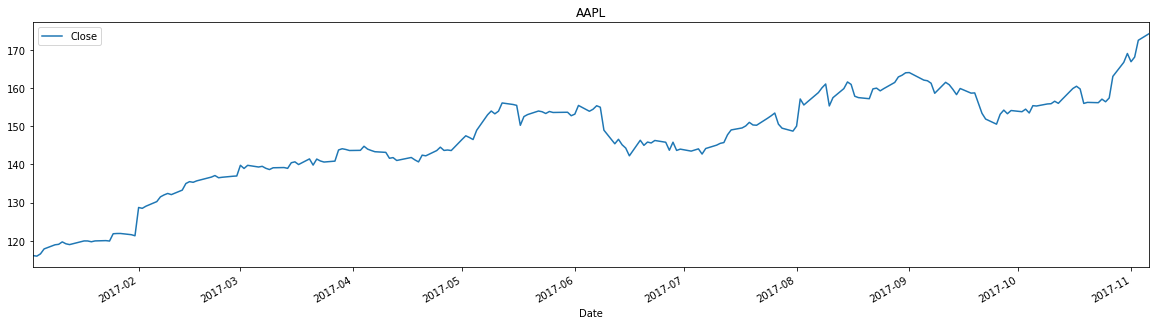

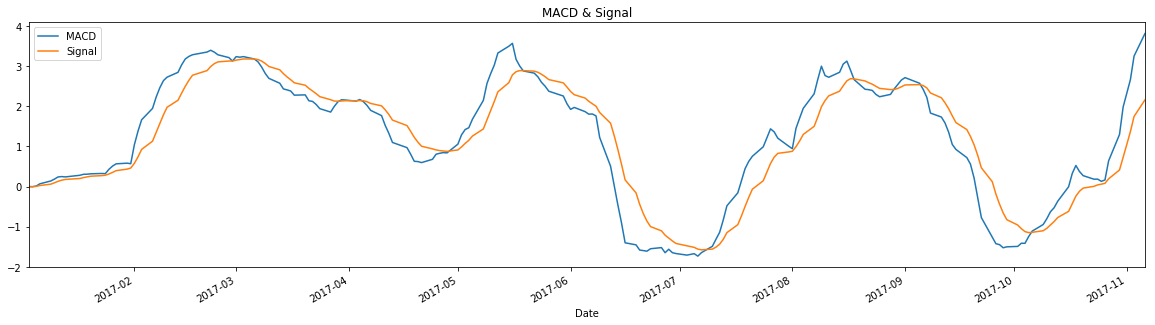

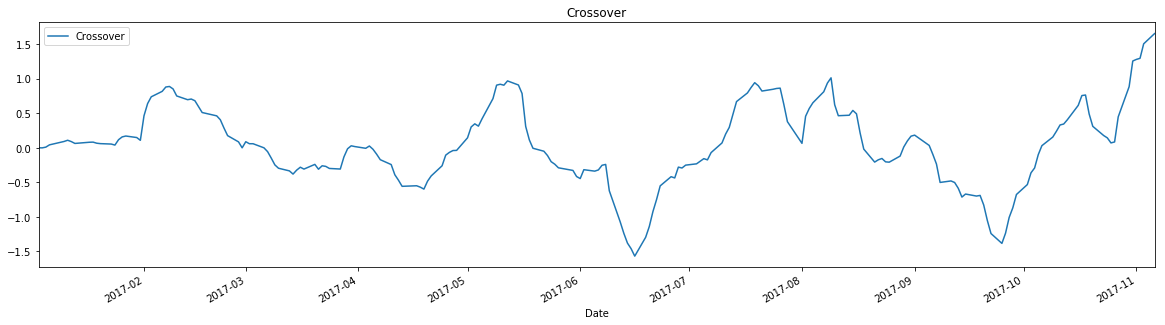

In [6]:
stock, date, macd = MACD("AAPL", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Apple stocks over a period of 10 months, coupled with a positive and rising 
# crossover value in Nov 17

### AMD

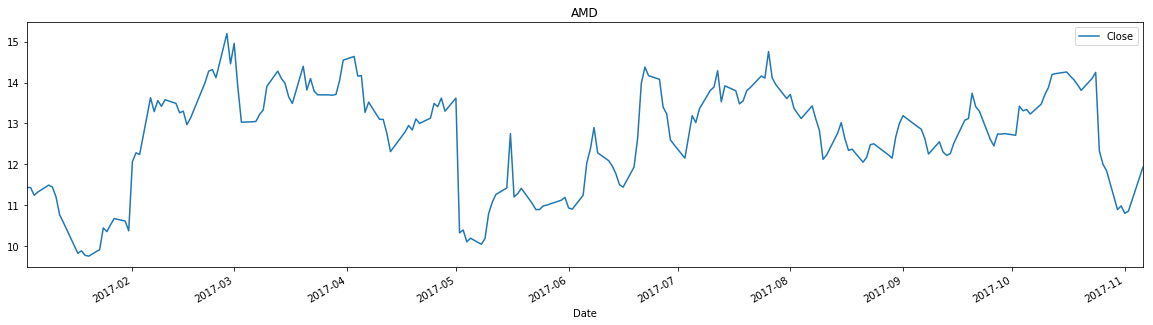

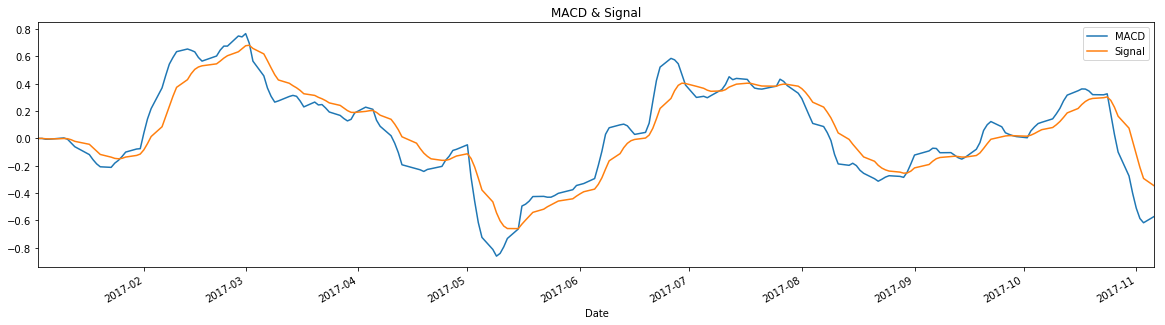

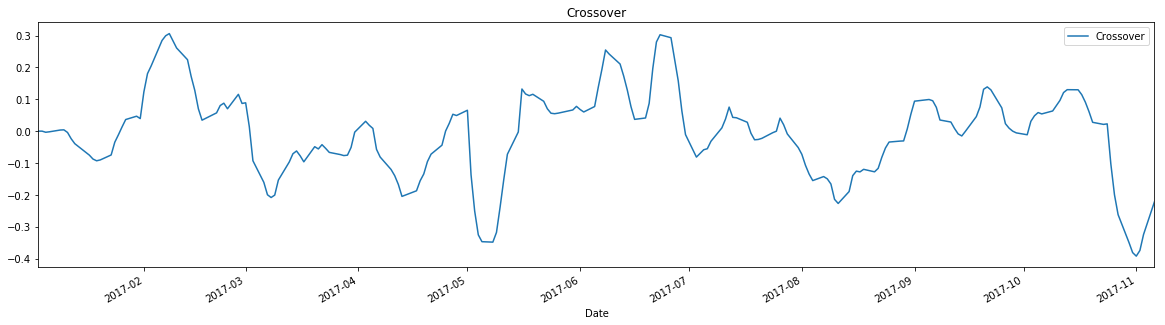

In [7]:
stock, date, macd = MACD("AMD", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for AMD stocks over a period of 10 months, and has a strong base formed at the crossover,
# hence, we expected the price to rise in the future. This is further backed by news of AMD corporation with Intel.

In [8]:
#stock, date, macd = MACD("GBTC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
#d.append({'Stock':stock, 'Date':date, 'MACD':macd})


### NVDA


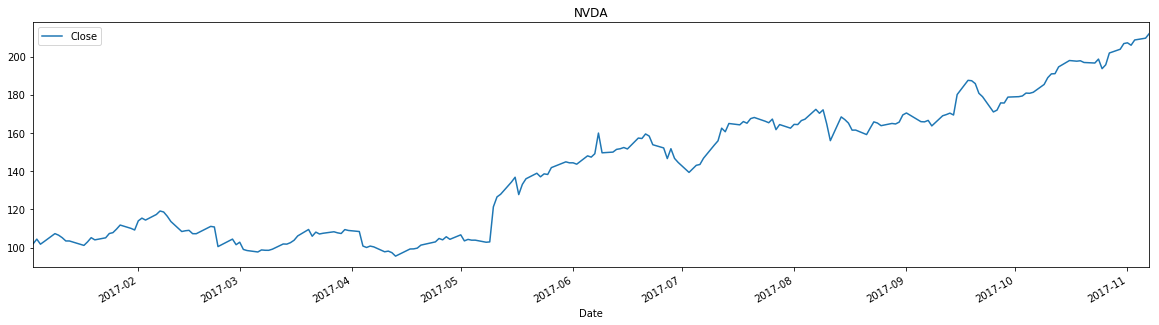

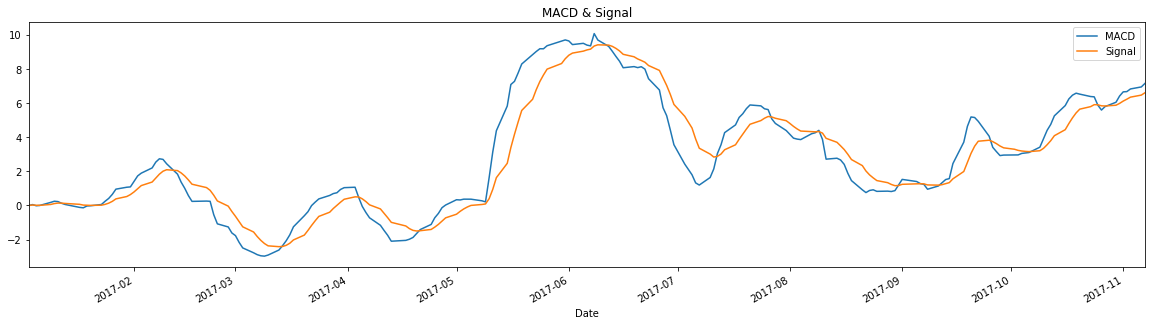

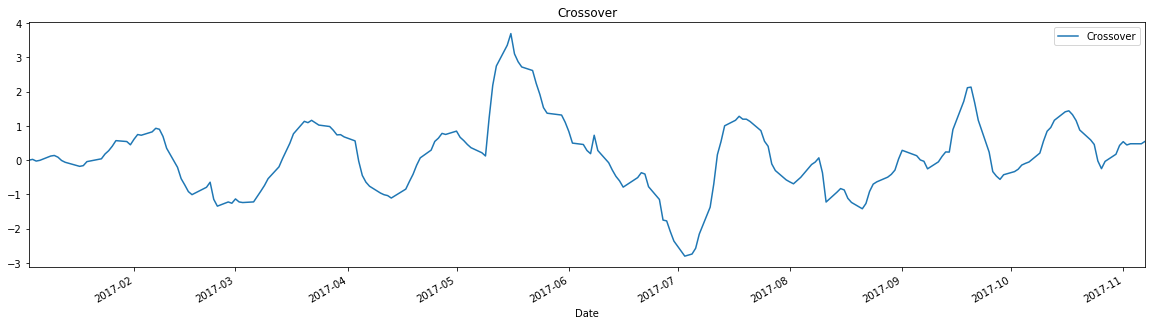

In [9]:
stock, date, macd = MACD("NVDA", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 7))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Nvidia stocks over a period of 10 months, coupled with a positive and rising 
# crossover value in Nov 17

### AVGO

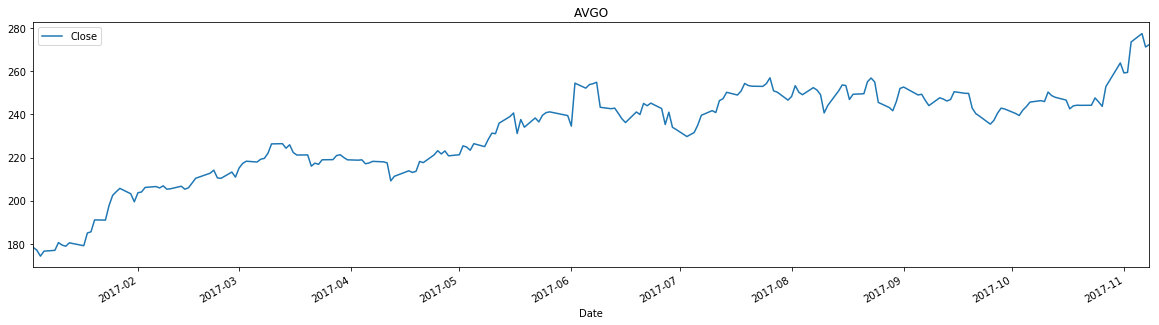

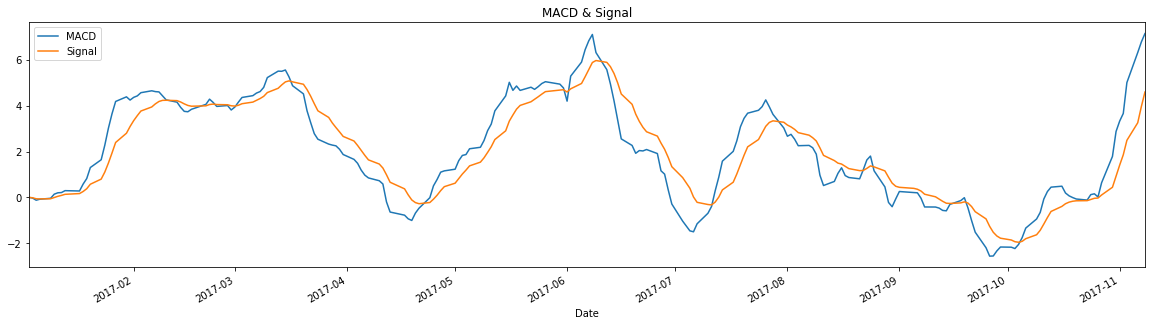

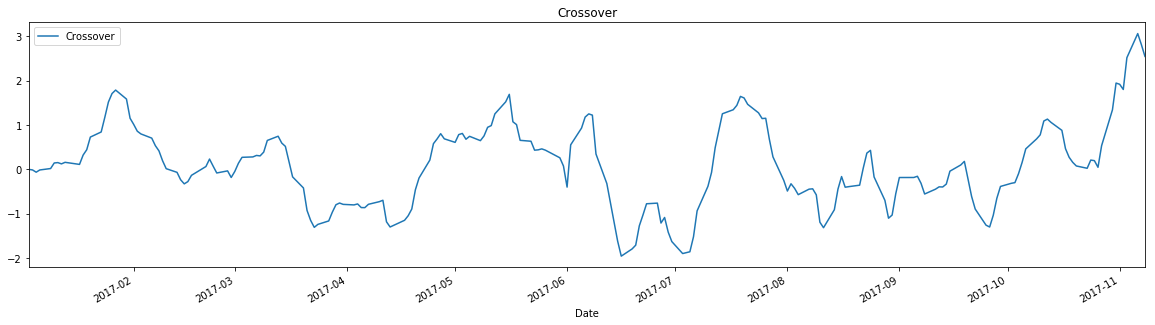

In [10]:
stock, date, macd = MACD("AVGO", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 8))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the stock prices to continue rising, despite the short drop in crossover. This is further backed by external 
# sources of news

### INTC

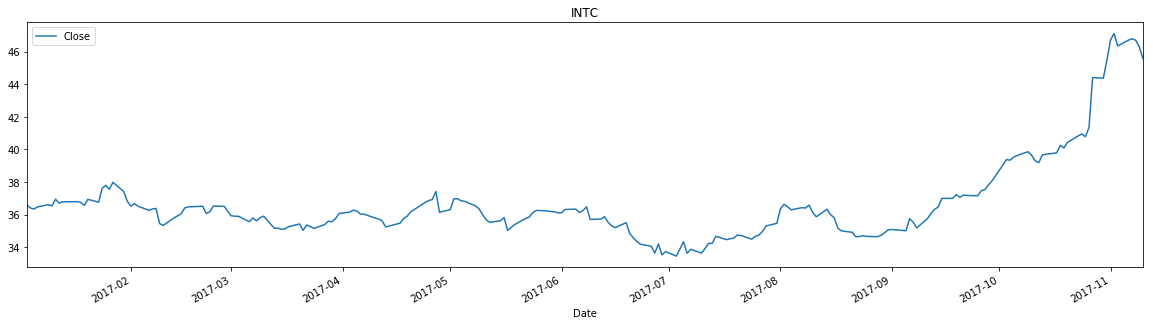

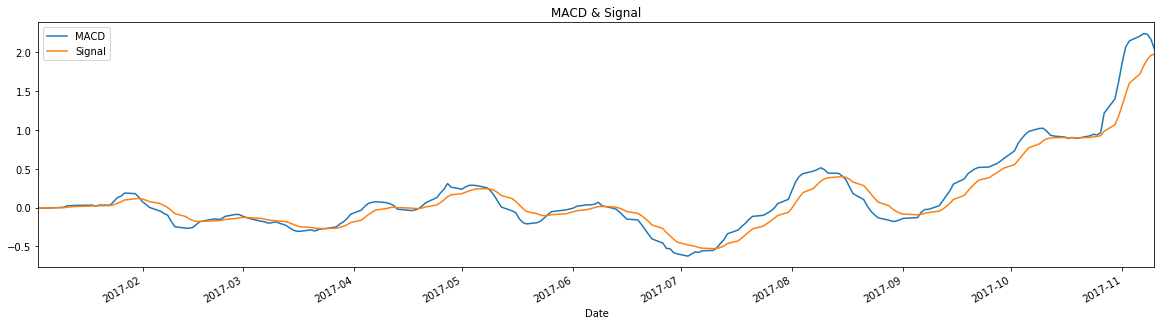

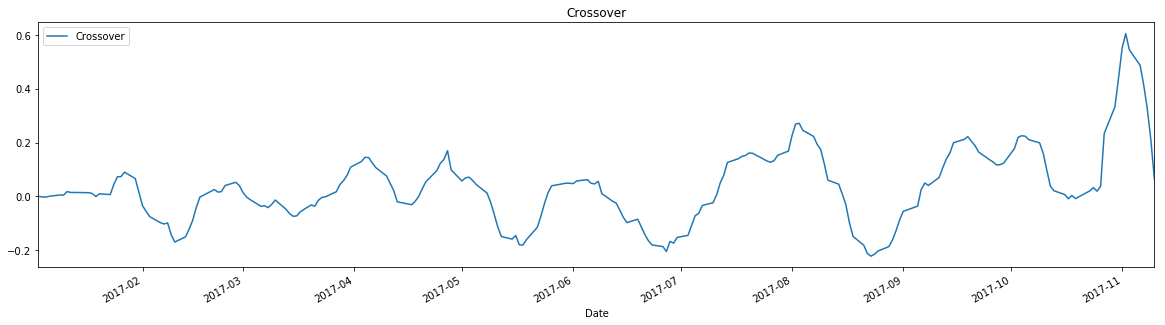

In [11]:
stock, date, macd = MACD("INTC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 10))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the stock prices to continue rising, despite the short drop in crossover. This is further backed by the news
# of AMD and Intel collaborating

### TXN

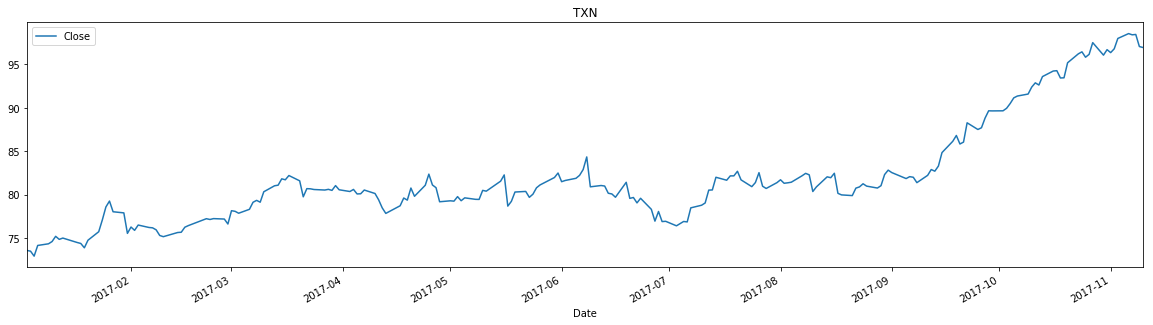

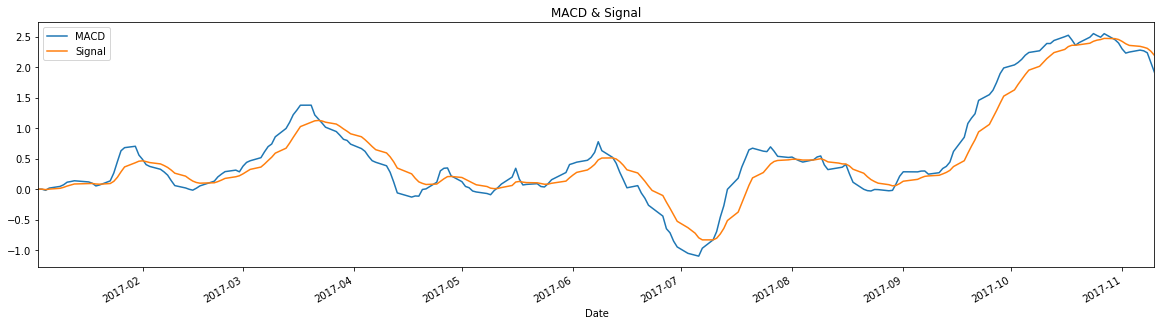

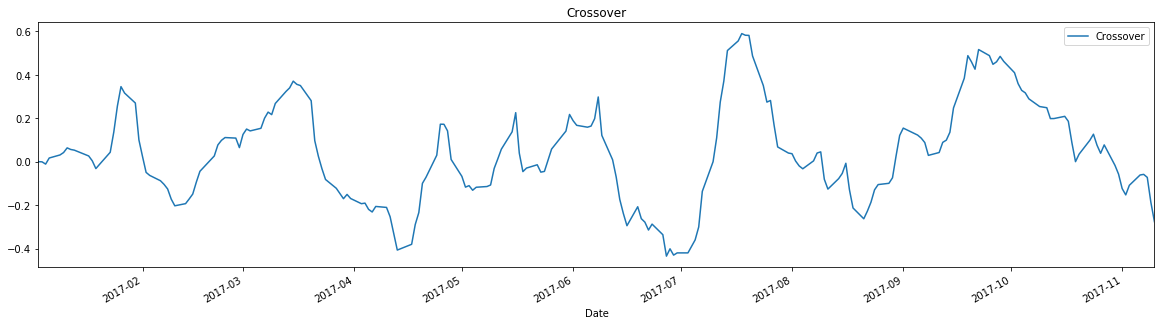

In [12]:
stock, date, macd = MACD("TXN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 10))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the crossover values to form the bottom at -0.4 soon, and rise in the near future.

### Amazon

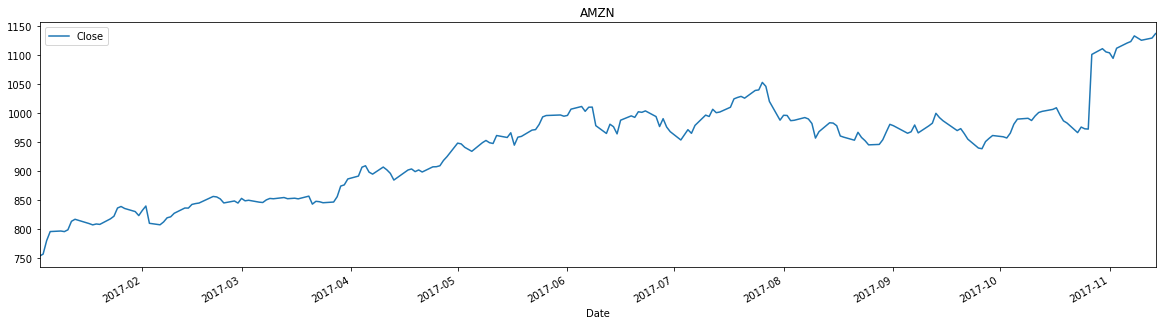

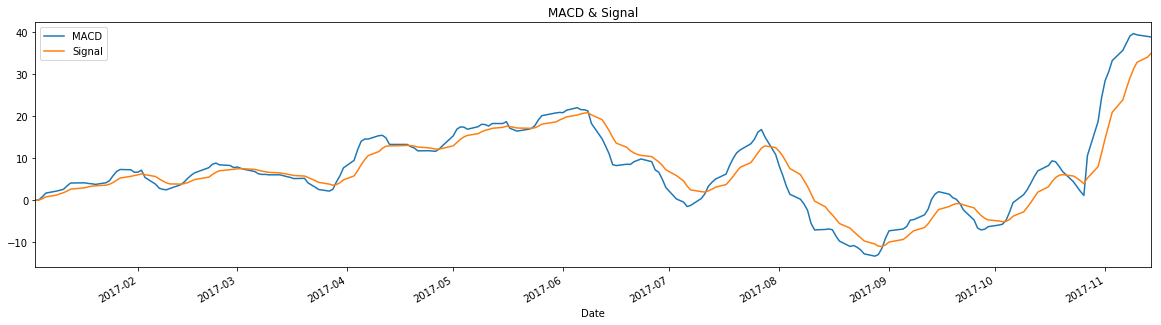

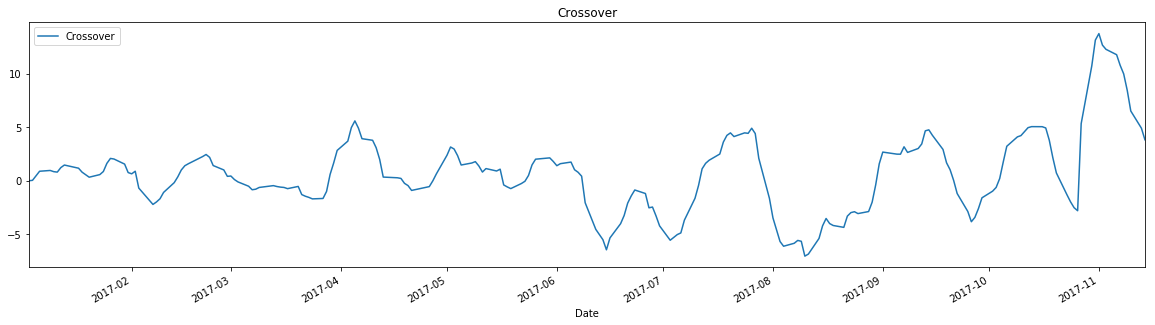

In [13]:
stock, date, macd = MACD("AMZN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 14))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Amazon stocks over a period of 10 months. Although the crossover value may not seem
# as positive, other indicators were used to make a decision to long.

## Bollinger Bands

Bollinger Bands provides the boundaries of the stock prices, indicating long or short when the prices exceed on either side. The middle line is calculated using the 20-day MA, and the boundaries are determined by adding and subtracting (20-day SD) x 2. Additionally, "the squeeze" is a strong indicator that there is future volatility. It is identified by the closing up of the bands, where volatility within this range is low. At this point, there is a strong calling for an entry into the market, and the direction can be estimated using the 20-day MA trend.

In [14]:
def Bollinger_Bands(stock, start, end):
    df = pd.DataFrame(web.DataReader(stock,'google',start,end)['Close'])
    df = df.reset_index()
    df['20 ma'] = df['Close'].rolling(window=20,center=False).mean()
    df['20 sd'] = df['Close'].rolling(window=20,center=False).std()
    df['Upper Band'] = df['20 ma'] + (df['20 sd']*2)
    df['Lower Band'] = df['20 ma'] - (df['20 sd']*2)
    print(stock)
    df = df.set_index('Date')
    #display(df.tail())
    df.plot(y=['Close','20 ma', 'Upper Band', 'Lower Band'], title='Bollinger Bands', figsize=(20, 5))
    plt.show()

#for stock in stocks:
#    Bollinger_Bands(stock, dt.datetime(2016, 1, 1), dt.datetime.today())
#    Bollinger_Bands(stock, dt.datetime(2017, 8, 19), dt.datetime.today())

stocks = ['AAPL', 'AMD', 'GBTC', 'NVDA', 'AVGO', 'INTC', 'TXN', 'AMZN']

AAPL


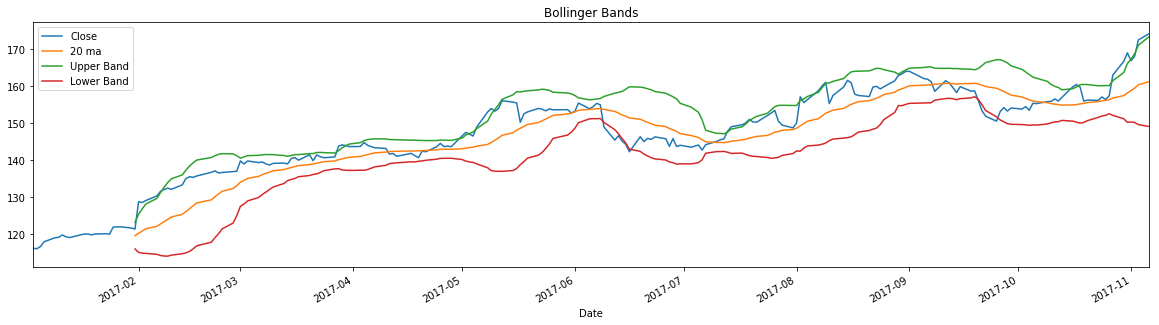

AAPL


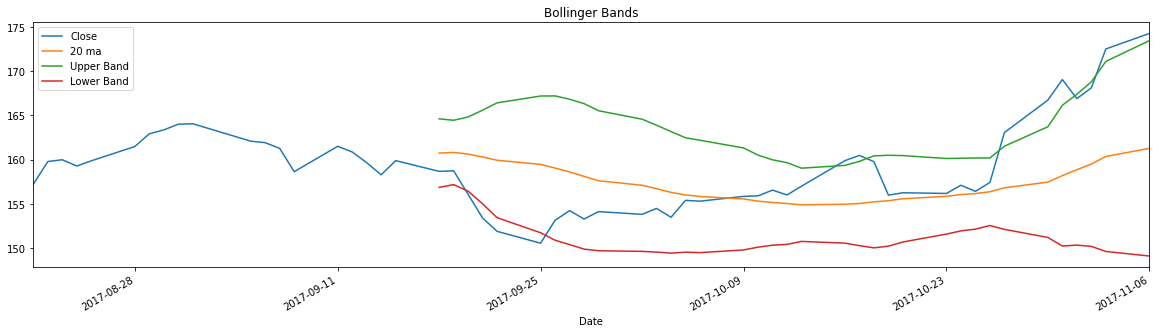

In [15]:
Bollinger_Bands("AAPL", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
Bollinger_Bands("AAPL", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

# We identified the squeeze nearing Nov 17, and expected the volatility to continue with the increasing trend

AMD


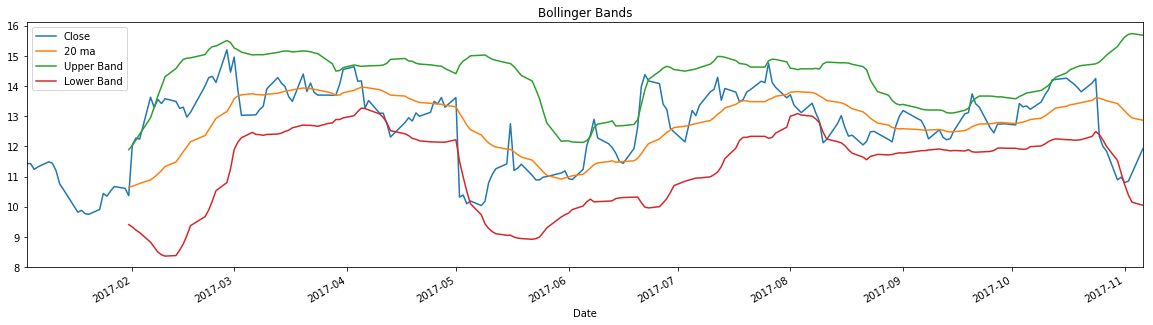

AMD


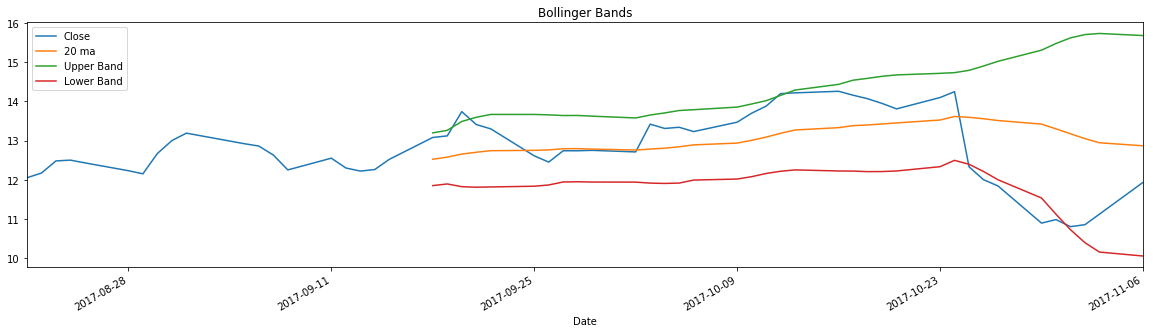

In [16]:
Bollinger_Bands("AMD", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
Bollinger_Bands("AMD", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

# The stock broked the lower bound and this signifies future drop in stock prices. However, we decided to purchase it with 
# strong indication from the news that it may rise

In [17]:
#Bollinger_Bands("GTBC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
#Bollinger_Bands("GBTC", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

NVDA


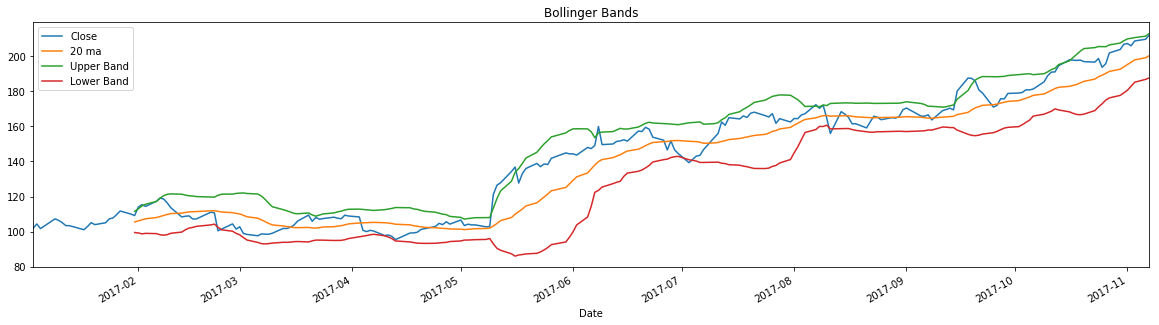

NVDA


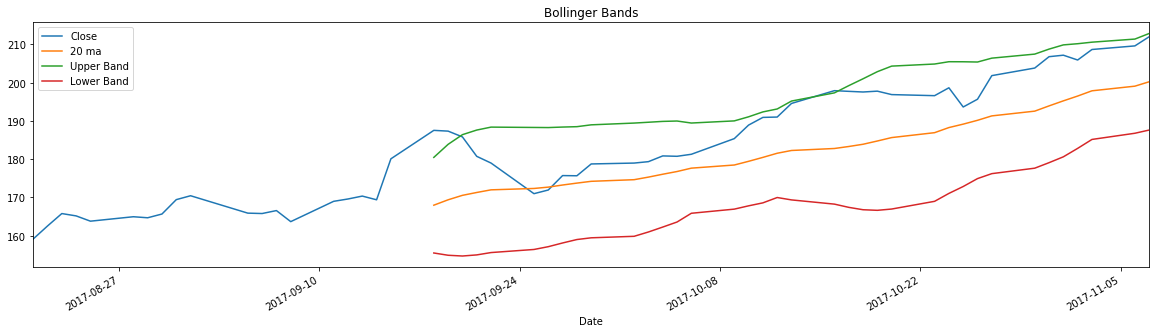

In [18]:
Bollinger_Bands("NVDA", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 7))
Bollinger_Bands("NVDA", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 7))

# We identified the squeeze from mid-Aug 17 till mid-Sept 17, and expected the volatility to continue with the increasing trend

AVGO


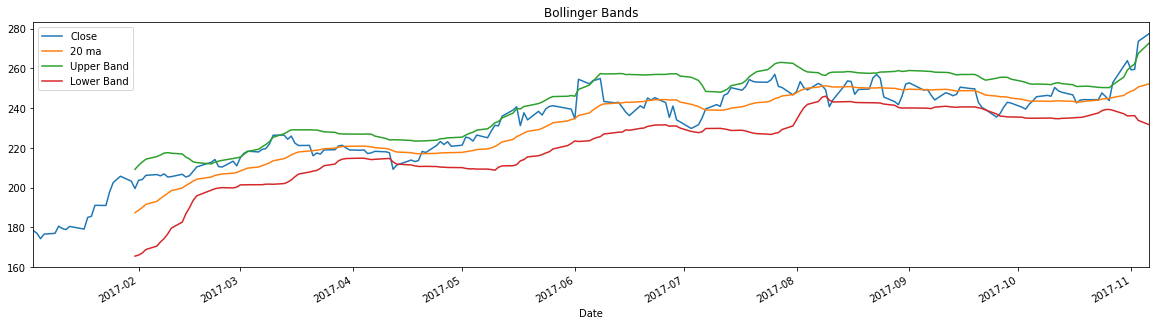

AVGO


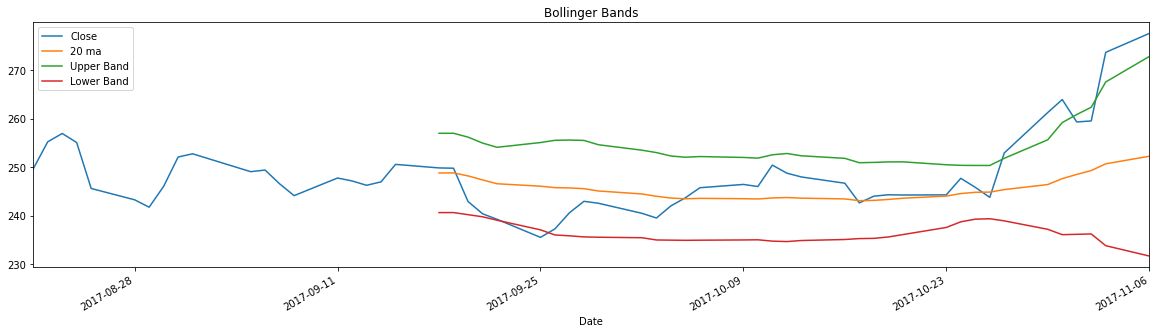

In [19]:
Bollinger_Bands("AVGO", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
Bollinger_Bands("AVGO", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

# We identified the squeeze from early Aug 17 till late Oct 17, and expected the volatility to increase and continue with the 
# increasing trend. Evidently, the stock prices broke the upper bound of the Bollinger Band

INTC


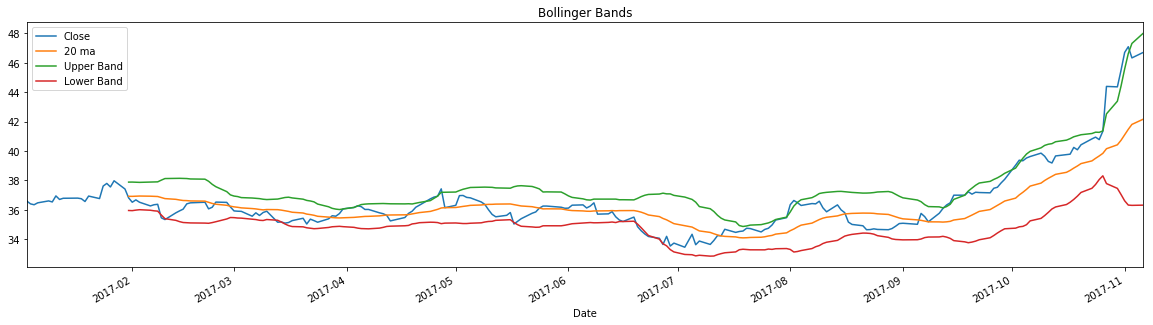

INTC


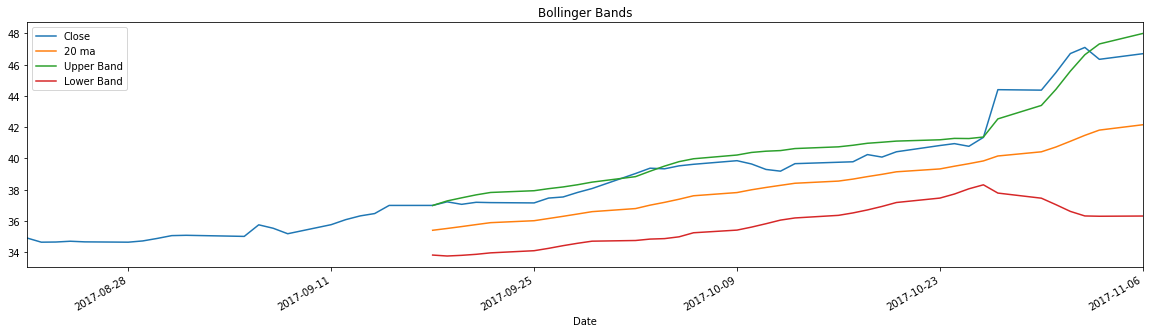

In [20]:
Bollinger_Bands("INTC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
Bollinger_Bands("INTC", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

# We identified a significant squeeze in late Oct 17, and expected the volatility to increase and continue with the 
# increasing trend. Evidently, the stock prices broke the upper bound of the Bollinger Band.

TXN


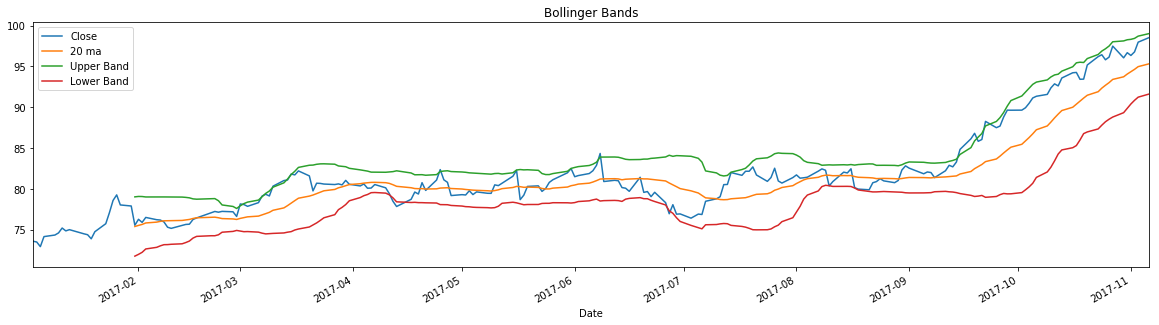

TXN


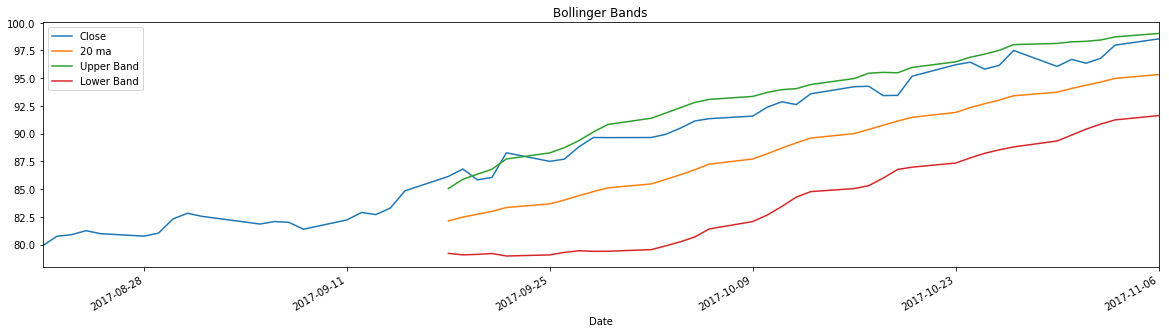

In [21]:
Bollinger_Bands("TXN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
Bollinger_Bands("TXN", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 6))

# We identified the squeeze from mid-Aug 17 till mid-Sept 17, and expected the volatility to increase and continue with the 
# increasing trend. There is a weak break in hte upper bound of the Bollinger band and the 20-day MA has a strong rising trend.

AMZN


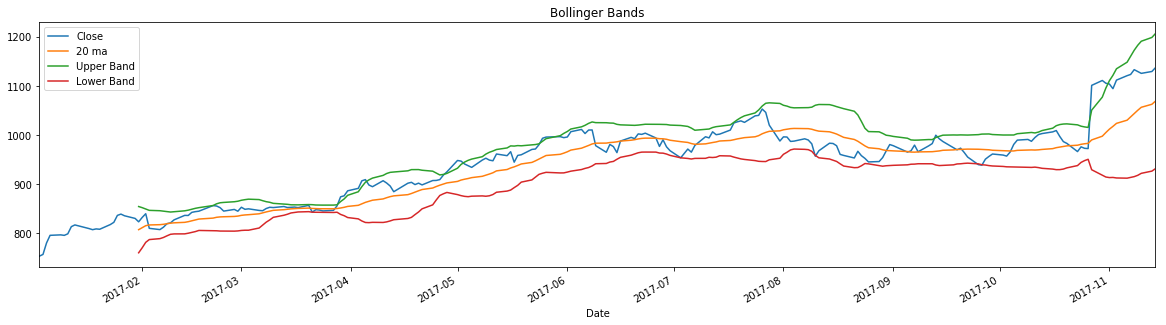

AMZN


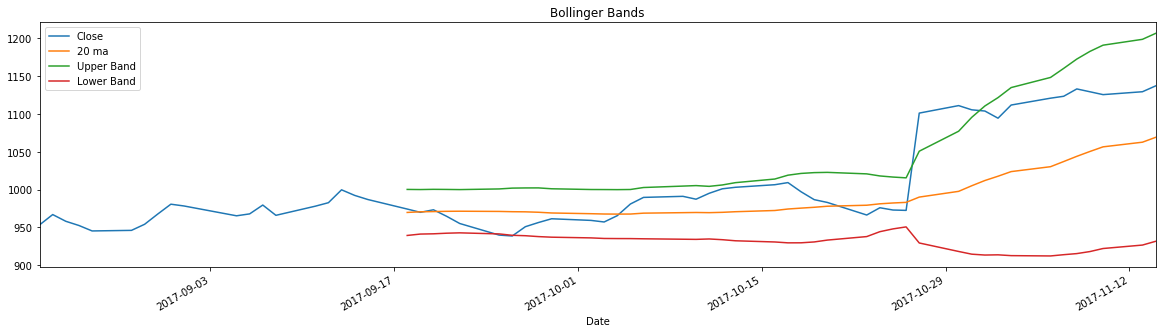

In [22]:
Bollinger_Bands("AMZN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 14))
Bollinger_Bands("AMZN", dt.datetime(2017, 8, 19), dt.datetime(2017, 11, 14))

# We identified the squeeze nearing Nov 17, and expected the volatility to continue with the increasing trend. 
# Evidently, the stock prices broke the upper bound of the Bollinger Band.

### Apple

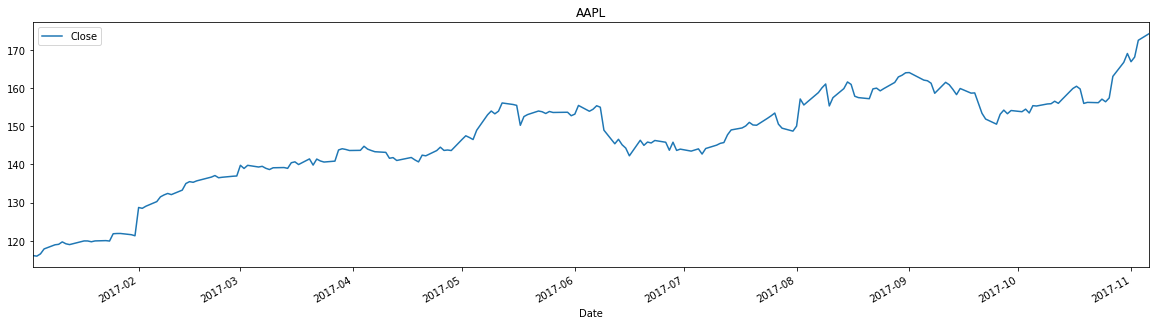

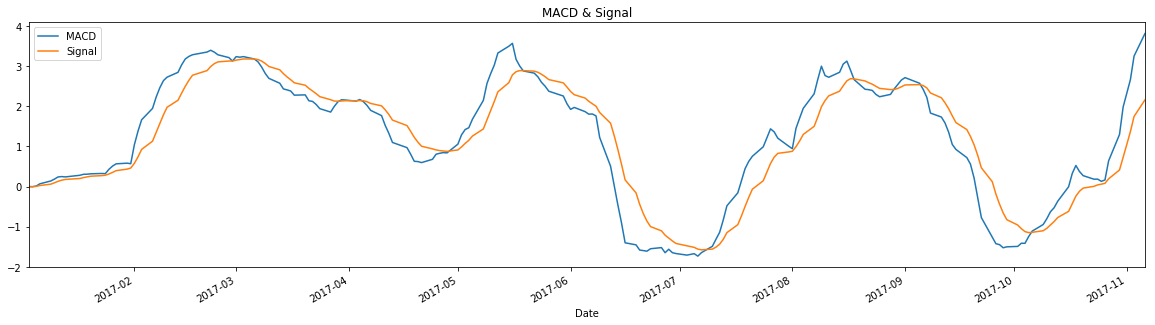

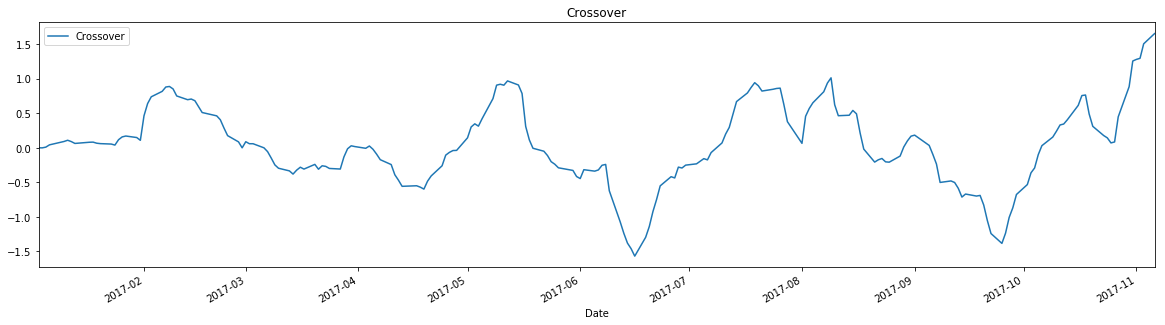

In [23]:
stock, date, macd = MACD("AAPL", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Apple stocks over a period of 10 months, coupled with a positive and rising 
# crossover value in Nov 17

### AMD

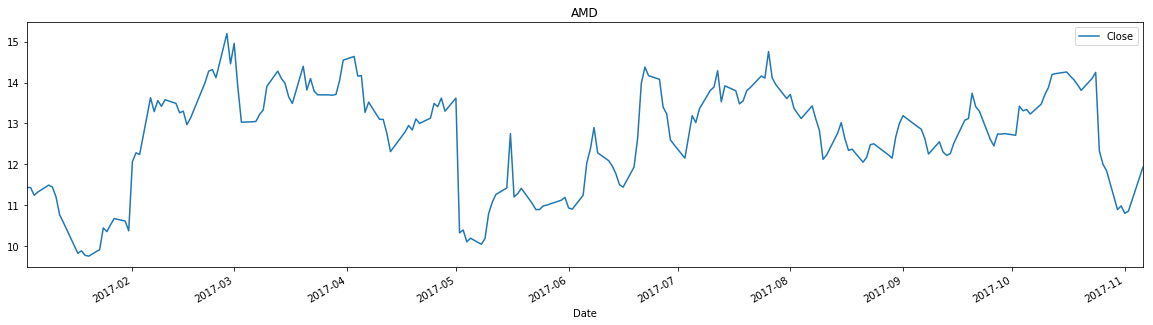

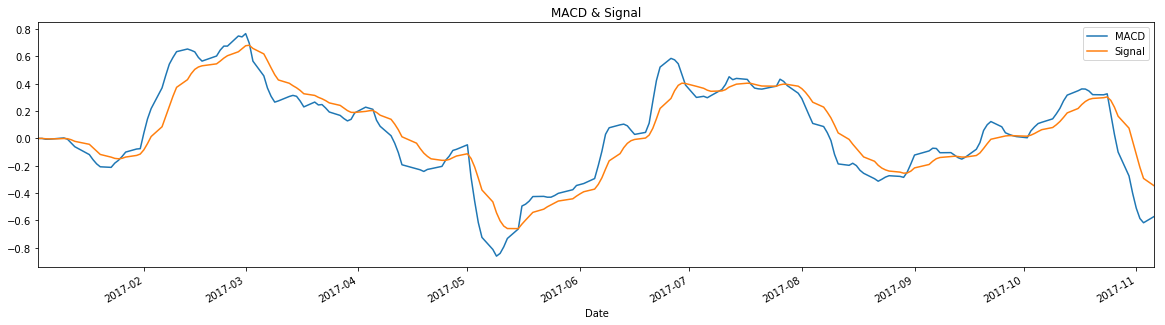

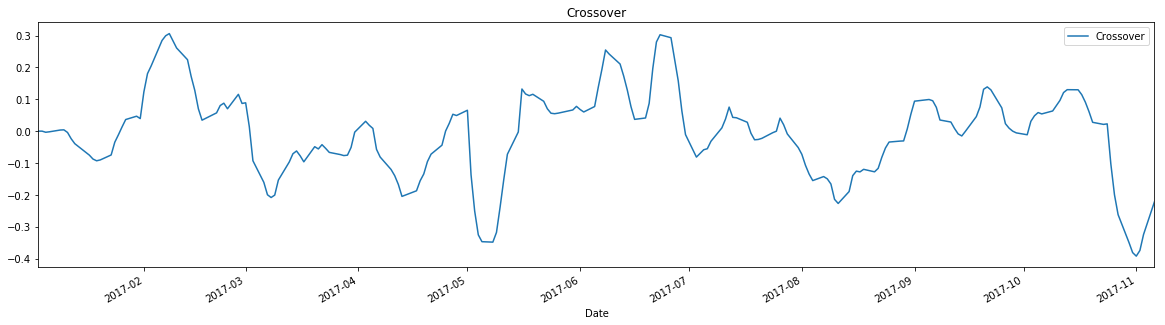

In [24]:
stock, date, macd = MACD("AMD", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for AMD stocks over a period of 10 months, and has a strong base formed at the crossover,
# hence, we expected the price to rise in the future. This is further backed by news of AMD corporation with Intel.

In [25]:
#stock, date, macd = MACD("GBTC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 6))
#d.append({'Stock':stock, 'Date':date, 'MACD':macd})


### NVDA


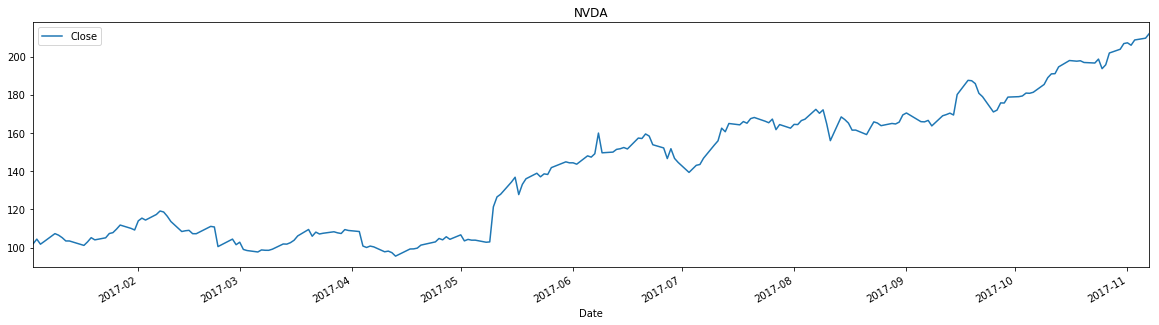

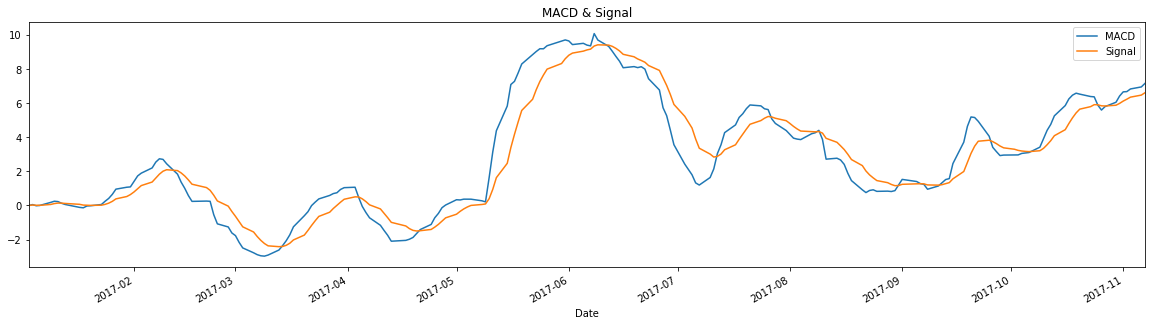

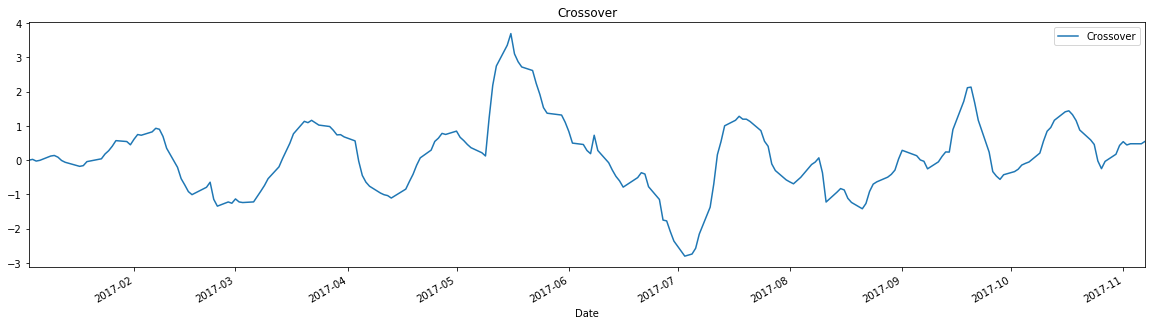

In [26]:
stock, date, macd = MACD("NVDA", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 7))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Nvidia stocks over a period of 10 months, coupled with a positive and rising 
# crossover value in Nov 17

### AVGO

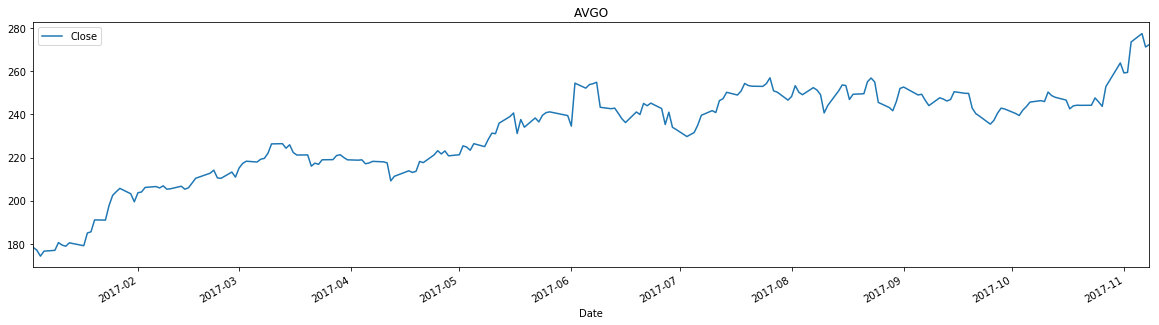

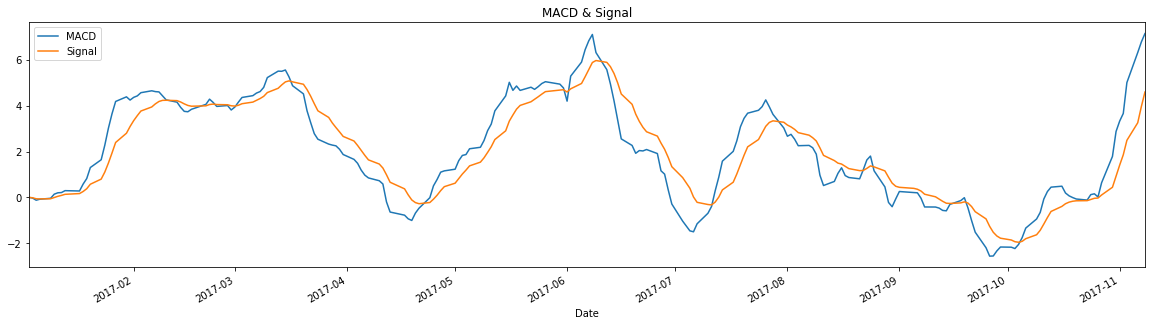

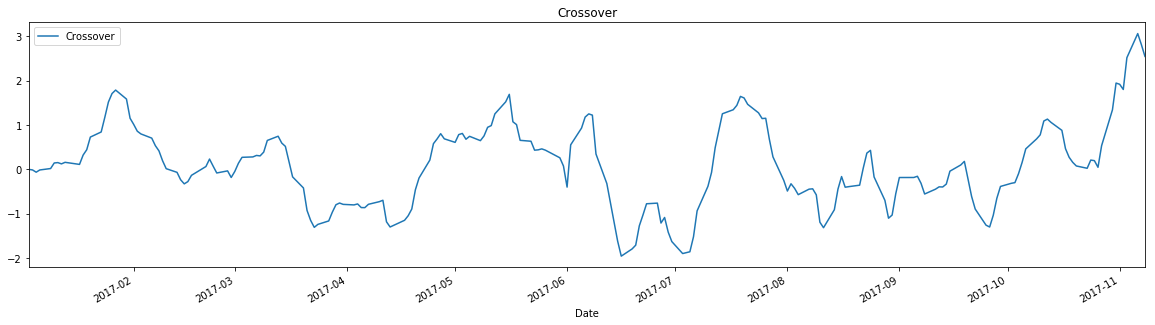

In [27]:
stock, date, macd = MACD("AVGO", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 8))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the stock prices to continue rising, despite the short drop in crossover. This is further backed by external 
# sources of news

### INTC

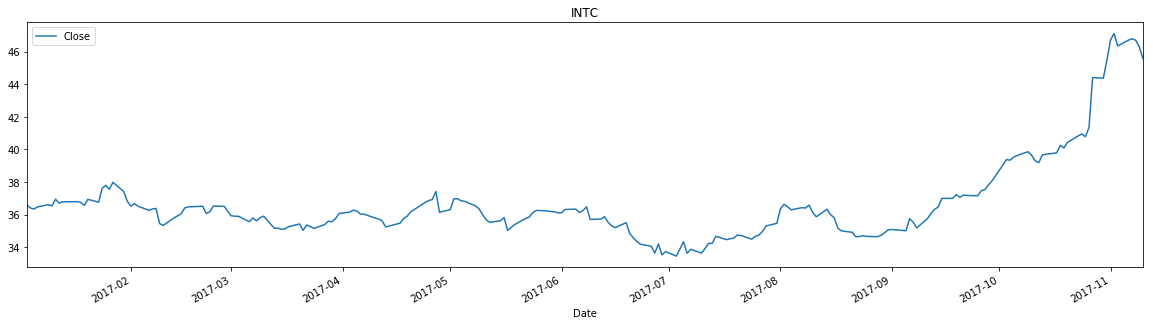

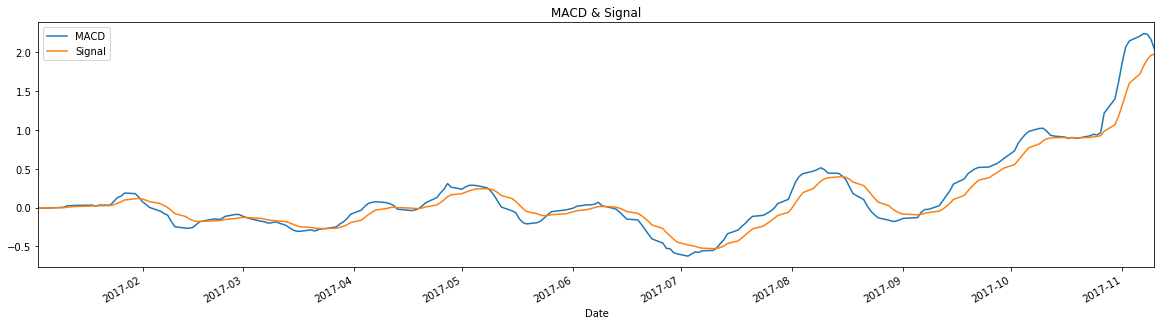

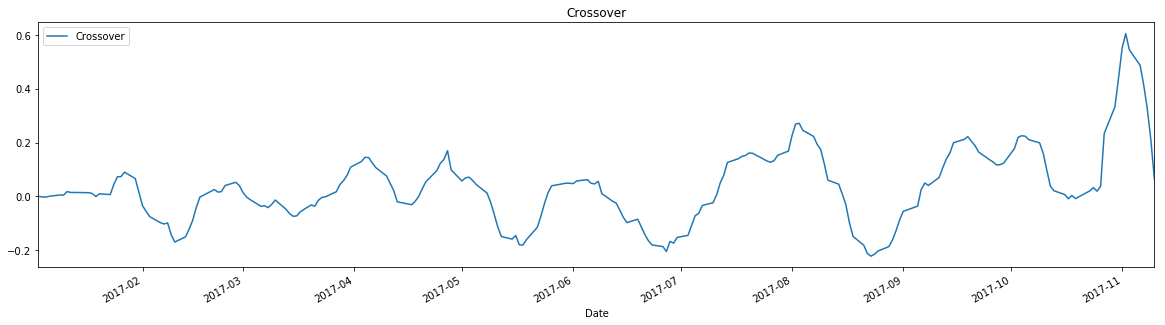

In [28]:
stock, date, macd = MACD("INTC", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 10))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the stock prices to continue rising, despite the short drop in crossover. This is further backed by the news
# of AMD and Intel collaborating

### TXN

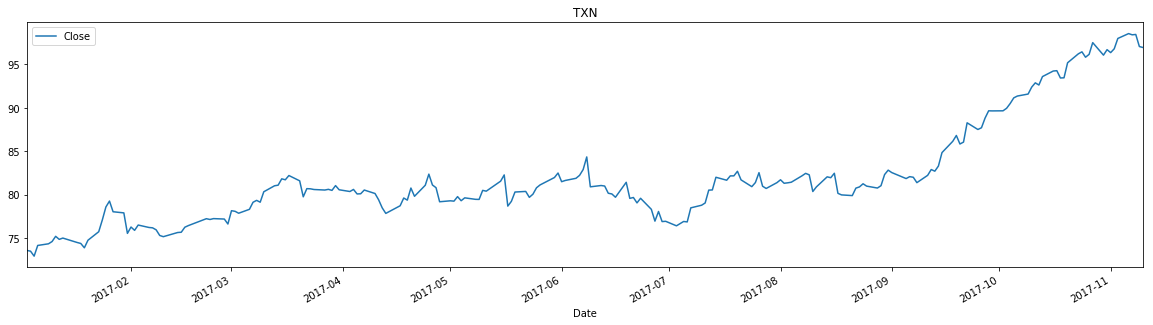

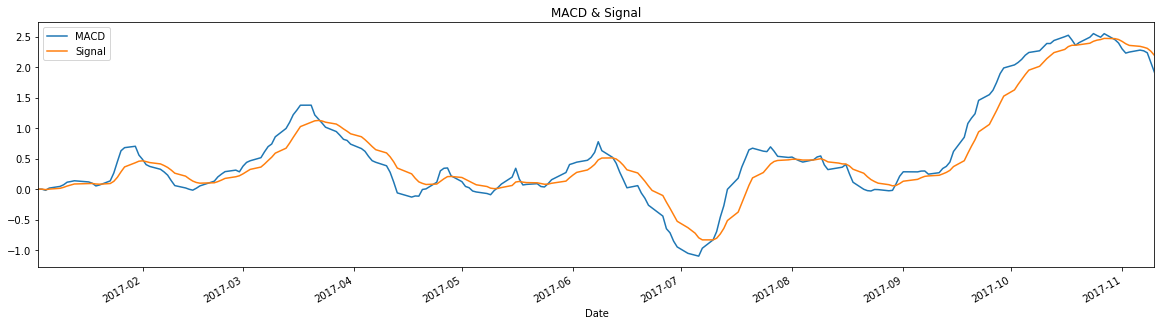

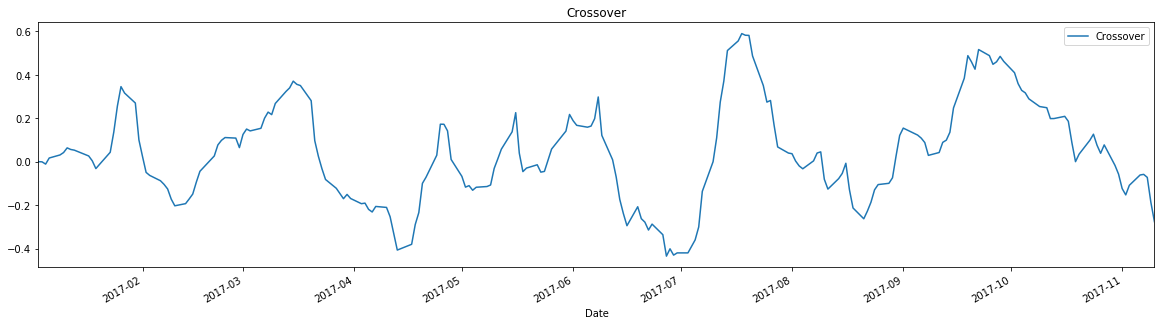

In [29]:
stock, date, macd = MACD("TXN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 10))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# We expected the crossover values to form the bottom at -0.4 soon, and rise in the near future.

### Amazon

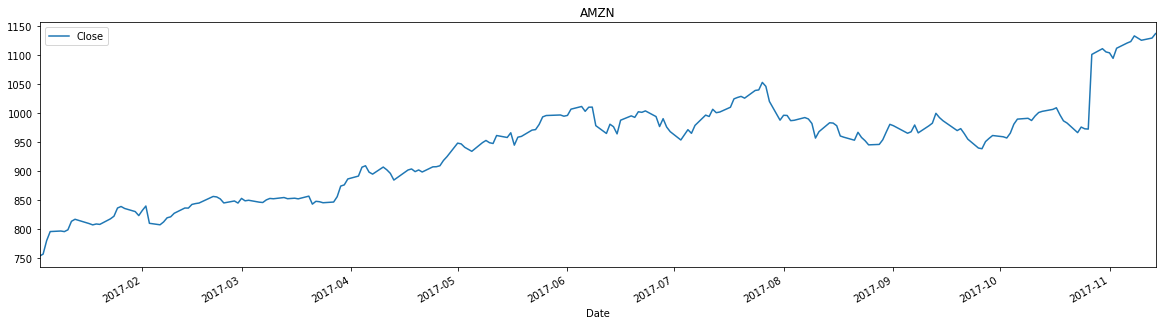

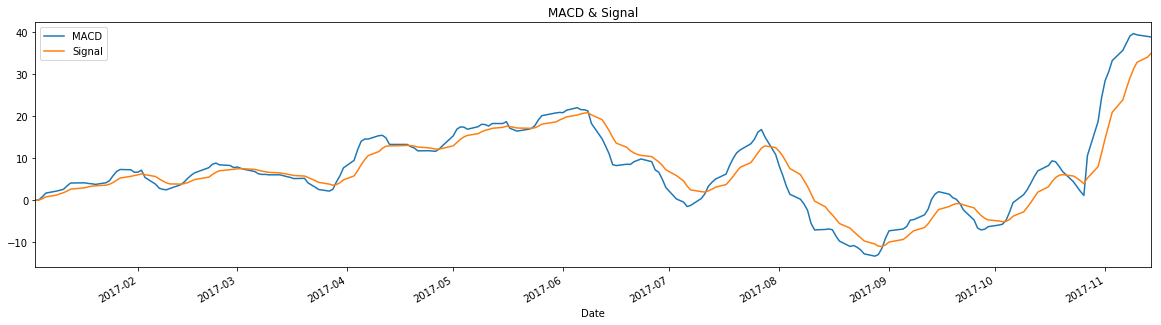

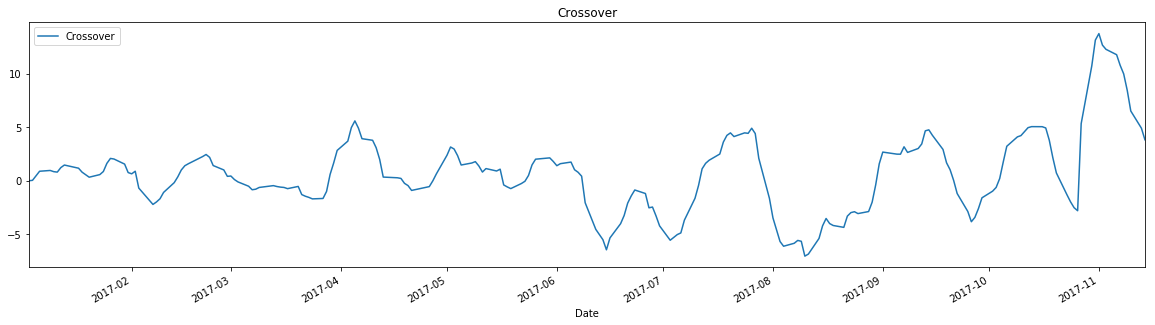

In [30]:
stock, date, macd = MACD("AMZN", dt.datetime(2017, 1, 1), dt.datetime(2017, 11, 14))
d.append({'Stock':stock, 'Date':date, 'MACD':macd})

# The plot depicts an upwards trend for Amazon stocks over a period of 10 months. Although the crossover value may not seem
# as positive, other indicators were used to make a decision to long.